# Introduction




## Installation

In [ ]:
!pip install geopandas -q
!pip install matplotlib mapclassify -q
!pip install folium==0.12.1.post1 -q
!pip install netCDF4 -q
!pip install rtree -q
!pip install geopy -q

In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/AIS_May_2021/__MACOSX/._AIS_May_2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import geopandas
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import numpy as np
import folium
from shapely.geometry import Point, Polygon, LineString
import shapely
import math
import xarray as xr
import statistics

In [ ]:
# Downloading Coordinate data
!wget -q https://www.microtransat.org/tracking/eastern_line.csv
!wget -q https://www.microtransat.org/tracking/western_line.csv
!wget https://apps-nefsc.fisheries.noaa.gov/drifter/drift_ep_2018_1.csv

--2022-04-30 04:30:21--  https://apps-nefsc.fisheries.noaa.gov/drifter/drift_ep_2018_1.csv
Resolving apps-nefsc.fisheries.noaa.gov (apps-nefsc.fisheries.noaa.gov)... 23.77.14.181, 2600:1417:9800:491::2580, 2600:1417:9800:4ac::2580
Connecting to apps-nefsc.fisheries.noaa.gov (apps-nefsc.fisheries.noaa.gov)|23.77.14.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342738 (335K) [text/csv]
Saving to: ‘drift_ep_2018_1.csv.2’

drift_ep_2018_1.csv 100%[===================>] 334.71K  1.60MB/s    in 0.2s    

2022-04-30 04:30:22 (1.60 MB/s) - ‘drift_ep_2018_1.csv.2’ saved [342738/342738]



### Microtransat Starting and Ending Lines


In [ ]:
eastern_line = pd.read_csv('eastern_line.csv').replace('"','')
western_line = pd.read_csv('western_line.csv')
eastern_line.columns = ['Latitude', 'Longitude']
western_line.columns = ['Latitude', 'Longitude']

In [ ]:
coords = list(zip(eastern_line['Longitude'], eastern_line['Latitude']))

In [ ]:
crs={'init':'epsg:4236'} # Coordinate Reference System
dummy_df = pd.DataFrame()
dummy_df['Attrib'] = [1,]
dummy_df2 = pd.DataFrame()
dummy_df2['Attrib'] = [1,]
east_geometry = LineString(list(zip(eastern_line['Longitude'], eastern_line['Latitude'])))
eastern_line_data = geopandas.GeoDataFrame(dummy_df, crs=crs, geometry=[east_geometry])
west_geometry = LineString(list(zip(western_line['Longitude'], western_line['Latitude'])))
western_line_data = geopandas.GeoDataFrame(dummy_df2, crs=crs, geometry=[west_geometry])

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### Improvements
https://plotly.com/python/map-configuration/


In [ ]:
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
lats = western_line["Latitude"].append(pd.Series(index=[0],data=[None])).append(eastern_line["Latitude"])
lons = western_line["Longitude"].append(pd.Series(index=[0],data=[None])).append(eastern_line["Longitude"])

In [ ]:
# print(lats)
# fig = px.line_geo(lat = lats, lon = lons)
# fig.update_geos(fitbounds="locations")
# fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

## Simulation Variables

North Atlantic Coordinates

 - Min. Lat 0° 56' 9.7" S (-0.936°)  
 - Min. Long 98° 3' 14.1" W (-98.0539°)  
 - Max. Lat 68° 38' 19.4" N (68.6387°)  
 - Max. Long 12° 0' 21.4" E (12.0059°) 

https://marineregions.org/gazetteer.php?p=details&amp;id=1912 

In [ ]:
na_minlat = 0
na_maxlat = 68
na_minlong = -98
na_maxlong = 12
na_bounds = [0, 68, -98, 12]

In [ ]:
def get_bounded_df(in_df, bounds):
  '''Takes in a dataframe, returns '''
  df = in_df.copy()
  if bounds[2] < 0:
    clone = df.copy()
    clone["lon"] = clone["lon"].subtract(360)
    df = pd.concat([df, clone], ignore_index=True)

  df.drop(df[df["lat"] < bounds[0]].index, inplace=True)
  df.drop(df[df["lat"] > bounds[1]].index, inplace=True)
  df.drop(df[df["lon"] < -100].index, inplace=True)
  df.drop(df[df["lon"] > bounds[3]].index, inplace=True)

  geopandas.GeoDataFrame(in_df, geometry=geopandas.points_from_xy(in_df.lon, in_df.lat)).drop(columns=['lat', 'lon'])
  return df

## Nautical charts
https://oceanservice.noaa.gov/facts/find-charts.html

Nautical charts are not in a python-friendly format, not really practical to write a parser.

Surface Currents Dataset: https://www.esr.org/research/oscar/overview/ <br> 
Surface Winds Dataset: https://data.noaa.gov/dataset/dataset/noaa-ncdc-blended-monthly-global-0-25-sea-surface-wind-stress-1987-2011-lon-1801 <br>
Datasets are in a folder in sharepoint

In [ ]:
xr.open_dataset('./data/uv201109.nc')

<xarray.Dataset>
Dimensions:  (lat: 719, lon: 1440, time: 1, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-15
  * zlev     (zlev) float32 10.0
  * lat      (lat) float32 -89.75 -89.5 -89.25 -89.0 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Data variables:
    u        (time, zlev, lat, lon) float32 ...
    v        (time, zlev, lat, lon) float32 ...
    w        (time, zlev, lat, lon) float32 ...
Attributes:
    Conventions:          COARDS, CF-1.0, Unidata Dataset Discovery v1.0
    title:                NOAA/NCDC Blended monthly 0.25-degree Sea Surface W...
    source:               Multiple satellite observations: DMSP SSMI F08, F10...
    summary:              Gridded and blended sea surface vector winds from m...
    Keywords:             sea winds, ocean winds, sea surface winds, air-sea ...
    references:           links at http://www.ncdc.noaa.gov/oa/rsad/blendedse...
    History:              Simple spatiotemporally weighted Interpolation (SI)...
    institution:          NOAA NESDIS National Climatic Data Center
    Contact:              Huai-Min.Zhang AT noaa.gov or satorder AT noaa.gov;...
    Acknowledgment:       The gridded data were generated from the multiple s...
    Data_Calendar_Month:  2011-09
    Comment:              The time in the netCDF should be the center of a ca...

In [ ]:
wind_ds = xr.open_dataset('./data/uv201109.nc').to_dataframe().dropna().reset_index()
print(wind_ds)

          lat     lon       time  zlev         u         v         w
0      -67.00  251.75 2011-09-15  10.0 -5.054535  4.214871  6.600000
1      -67.00  252.00 2011-09-15  10.0 -5.165112  4.272970  6.722767
2      -67.00  252.25 2011-09-15  10.0 -5.178491  4.265494  6.728320
3      -67.00  252.50 2011-09-15  10.0 -5.191382  4.257707  6.733334
4      -67.00  252.75 2011-09-15  10.0 -5.204234  4.249912  6.738347
...       ...     ...        ...   ...       ...       ...       ...
554631  82.75   58.00 2011-09-15  10.0 -0.940350  2.065869  2.280341
554632  82.75   58.25 2011-09-15  10.0 -0.936092  2.088088  2.298294
554633  82.75   58.50 2011-09-15  10.0 -0.883965  2.004193  2.199427
554634  82.75   58.75 2011-09-15  10.0 -0.872314  2.008617  2.198282
554635  82.75   59.00 2011-09-15  10.0 -0.783933  1.832076  2.000000

[554636 rows x 7 columns]


In [ ]:
xr.open_dataset('./data/oscar_currents_interim_20211231.nc')

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 1)
Coordinates:
    lat      (latitude) float64 ...
    lon      (longitude) float64 ...
  * time     (time) object 2021-12-31 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 ...
    v        (time, longitude, latitude) float64 ...
    ug       (time, longitude, latitude) float64 ...
    vg       (time, longitude, latitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_INTERIM_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2021-12-31T00:00:00
    time_coverage_end:          2021-12-31T23:59:59
    date_created:               2022-01-17

In [ ]:
current_ds = xr.open_dataset('data/oscar_currents_interim_20211231.nc').to_dataframe().dropna()
print(current_ds.head())

                                          lat     lon         u         v  \
latitude longitude time                                                     
46       783       2021-12-31 00:00:00 -78.25  195.75 -0.064467 -0.010470   
         784       2021-12-31 00:00:00 -78.25  196.00 -0.053568  0.006643   
47       746       2021-12-31 00:00:00 -78.00  186.50 -0.044589 -0.069110   
         747       2021-12-31 00:00:00 -78.00  186.75 -0.047297 -0.063138   
         748       2021-12-31 00:00:00 -78.00  187.00 -0.050756 -0.070046   

                                              ug        vg  
latitude longitude time                                     
46       783       2021-12-31 00:00:00 -0.056231 -0.006073  
         784       2021-12-31 00:00:00 -0.045923  0.012826  
47       746       2021-12-31 00:00:00 -0.023848 -0.067776  
         747       2021-12-31 00:00:00 -0.026721 -0.064296  
         748       2021-12-31 00:00:00 -0.029439 -0.074936  


In [ ]:
current_ds.size

3520518

## Regridding

### Create GeoDataFrames

In [ ]:
current_gdf = geopandas.GeoDataFrame(current_ds, geometry=geopandas.points_from_xy(current_ds.lon, current_ds.lat))
current_gdf = current_gdf.drop(columns=['lat', 'lon'])

wind_gdf = geopandas.GeoDataFrame(wind_ds, geometry=geopandas.points_from_xy(wind_ds.lon, wind_ds.lat))
wind_gdf = wind_gdf.drop(columns=['lat', 'lon'])

#### Documentation
https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.cov.html
https://stats.stackexchange.com/questions/120179/generating-data-with-a-given-sample-covariance-matrix


In [ ]:
def grid_data(gdf: geopandas.GeoDataFrame, scale: tuple, dim: tuple, aggfunc='mean'):
  """
  Args: 
    gdf: GeoPandas Dataframe to be gridded 
    scale: 2-tuple with the size of cells in x,y directions (degrees)
    dim: Total dimensions being considered

  Returns:
    cell: New gdf with average gridding applied
  """
  # Create cells
  
  # Properties of the grid: 
  if dim is not None:
    xmin, ymin, xmax, ymax = dim
  else:
    xmin, ymin, xmax, ymax = gdf.total_bounds
  
  x_cell_size = scale[0]
  y_cell_size = scale[1]

  print(x_cell_size, "x size ", y_cell_size, "y size")

  # Iterate over all cells and create bounding box
  grid_cells = []
  for x0 in np.arange(xmin, xmax, x_cell_size):
    for y0 in np.arange(ymin, ymax, y_cell_size):
      x1 = x0+x_cell_size
      y1 = y0+y_cell_size
      grid_cells.append(shapely.geometry.box(x0,y0,x1,y1))

  print(len(grid_cells), "cells created")

  # Collect all boxes into geodataframe
  cell=geopandas.GeoDataFrame(grid_cells, columns=['geometry'])

  # Dissolve data into cells by averaging
  merged = geopandas.sjoin(gdf, cell, how='left', op='within')
  dissolve = merged.dissolve(by='index_right', aggfunc=aggfunc)
  
  # Transfer data to cells
  for column, data in dissolve.iteritems():
    if column != "geometry":
      cell.loc[dissolve.index, column] = data.values
  return cell

In [ ]:
current_gdf.head()

u         v        ug  \
latitude longitude time                                                
46       783       2021-12-31 00:00:00 -0.064467 -0.010470 -0.056231   
         784       2021-12-31 00:00:00 -0.053568  0.006643 -0.045923   
47       746       2021-12-31 00:00:00 -0.044589 -0.069110 -0.023848   
         747       2021-12-31 00:00:00 -0.047297 -0.063138 -0.026721   
         748       2021-12-31 00:00:00 -0.050756 -0.070046 -0.029439   

                                              vg                 geometry  
latitude longitude time                                                    
46       783       2021-12-31 00:00:00 -0.006073  POINT (195.750 -78.250)  
         784       2021-12-31 00:00:00  0.012826  POINT (196.000 -78.250)  
47       746       2021-12-31 00:00:00 -0.067776  POINT (186.500 -78.000)  
         747       2021-12-31 00:00:00 -0.064296  POINT (186.750 -78.000)  
         748       2021-12-31 00:00:00 -0.074936  POINT (187.000 -78.000)

In [ ]:
na_winds_df = get_bounded_df(current_ds, na_bounds)
na_currents_df = get_bounded_df(wind_ds, na_bounds)

In [ ]:
na_currents_gdf = geopandas.GeoDataFrame(na_currents_df, geometry=geopandas.points_from_xy(na_currents_df.lon, na_currents_df.lat)).drop(columns=['lat', 'lon'])
na_winds_gdf = geopandas.GeoDataFrame(na_winds_df, geometry=geopandas.points_from_xy(na_winds_df.lon, na_winds_df.lat)).drop(columns=['lat', 'lon'])

In [ ]:
na_currents_gdf.head()

,time,zlev,u,v,w,geometry
302508,2011-09-15,10.0,-0.634653,5.515023,6.324830,POINT (0.00000 0.00000)
302509,2011-09-15,10.0,-0.638503,5.502288,6.287267,POINT (0.25000 0.00000)
302510,2011-09-15,10.0,-0.623907,5.437766,6.254910,POINT (0.50000 0.00000)
302511,2011-09-15,10.0,-0.524107,5.514946,6.298137,POINT (0.75000 0.00000)
302512,2011-09-15,10.0,-0.486545,5.484176,6.256761,POINT (1.00000 0.00000)


## Maritime Traffic

Using Automatic Identification System (AIS) data from [NOAA](https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/index.html), we are able to track vessels as they travel along the east coast of the US. Our sample contains data for the month of May 2021. 

The tracks are not completely accurate as they are formed by connecting two points (longitude, lattitude) that contain the vessel's location at two different times. The location in between these two points is unknown, resulting in a straight line connecting them that may not be the actual path taken. 



In [ ]:
df = pd.read_csv('./data/AIS_May_2021/AIS_May_2021.csv')

In [ ]:
def get_boat_track(mmsi, df, min_dist=0.001, max_dist=0.01):
  ais_df_copy = df[df['MMSI'] == mmsi].sort_values('BaseDateTime')
  ais_df_copy['diff'] = abs(ais_df_copy['LAT'].diff()) + abs(ais_df_copy['LON'].diff())
  ais_df_copy = ais_df_copy[ais_df_copy['diff'] > min_dist]
  ais_df_copy = ais_df_copy[ais_df_copy['diff'] < max_dist]

  lats = ais_df_copy['LAT'].reset_index(drop=True)
  lats.append(pd.Series(index=[0], data=[None]))
  lons = ais_df_copy['LON'].reset_index(drop=True)
  lons.append(pd.Series(index=[0], data=[None]))

  return lats, lons

In [ ]:
def show_boat_tracks(df, num_tracks=1000, min_dist=0.001, max_dist=0.01):
  fig = go.Figure()
  df = df.sample(frac=1)
  
  for mmsi in df['MMSI'].unique():
    lat, lon = get_boat_track(mmsi, df, min_dist=min_dist, max_dist=max_dist)
    fig.add_trace(go.Scattergeo(
        lon = lon, 
        lat = lat, 
        mode = 'lines', 
        line = dict(width = 2),
        opacity = .6)
    )

    num_tracks -= 1
    if num_tracks == 0: 
      break

  fig.update_geos(fitbounds="locations")
  fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0}, showlegend=False)
  fig.show()

In [ ]:
def show_boats(df, num_boats=1000, min_dist=0.001, max_dist=0.003):
  fig = go.Figure()
  df = df.sample(frac=1)
  
  for mmsi in df['MMSI'].unique():
    lat = df[df['MMSI'] == mmsi]['LAT'][0:1]
    lon = df[df['MMSI'] == mmsi]['LON'][0:1]
    fig.add_trace(go.Scattergeo(
        lon = lon[0:1], 
        lat = lat[0:1], 
        marker = dict(
            size = 3,
            line_width=0.1,
            opacity = .2,
            color = 'red')
        ))

    num_boats -= 1
    if num_boats == 0: 
      break

  fig.update_geos(fitbounds="locations")
  fig.update_layout(height=300, margin={"r":0,"t":0,"l":0,"b":0}, showlegend = False)
  fig.show()

In [ ]:
# show_boat_tracks(df, num_tracks = 200)

In [ ]:
# show_boats(df, num_boats = 3000)

In [ ]:
def show_boat_density(df, bin):
  x = df['LON']
  y = df['LAT']
  heatmap, xedges, yedges = np.histogram2d(x, y, bins=bin)
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='jet')
  plt.show()

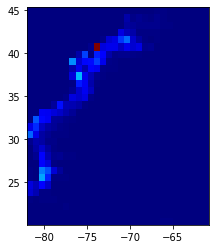

In [ ]:
ais_df = pd.read_csv('./data/AIS_May_2021/AIS_May_2021.csv')
show_boat_density(ais_df, 30)

In [ ]:
traffic_gdf = geopandas.GeoDataFrame(ais_df, geometry=geopandas.points_from_xy(ais_df['LON'], ais_df['LAT']))
traffic_gdf = traffic_gdf.drop(columns=['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG'])

https://www.robsonforensic.com/articles/visibility-factors-in-small-boat-collisions-expert-research

In [ ]:
bounds = na_currents_gdf.total_bounds

In [ ]:
traffic_gdf.head()

,geometry
0,POINT (-79.70614 27.81761)
1,POINT (-75.12950 36.73923)
2,POINT (-73.90155 40.56954)
3,POINT (-76.07849 37.35700)
4,POINT (-79.63229 32.64091)


In [ ]:
traffic_gdf['n']=1

In [ ]:
grid_na_t_gdf = grid_data(traffic_gdf, (1, 1), bounds, aggfunc='count').fillna(value={'n': 0})

1 x size  1 y size
7616 cells created


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Kinematic Model

https://www.aoml.noaa.gov/phod/gdp/faq.php#sst
Drift buoys go at speed of surface current

In [ ]:
# Create combined regridded df
grid_na_c_gdf = grid_data(na_currents_gdf, (1, 1), None)
grid_na_w_gdf = grid_data(na_winds_gdf, (1, 1), None)

combined_gdf = grid_na_c_gdf.merge(grid_na_w_gdf, on='geometry')

1 x size  1 y size
7616 cells created


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


1 x size  1 y size
7616 cells created


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Add in maritime traffic

grid_na_t_gdf['n'] = grid_na_t_gdf['n'].mask(grid_na_c_gdf['zlev'].isnull())



(-105.59999999999998, 17.6, -3.4000000000000004, 71.4)

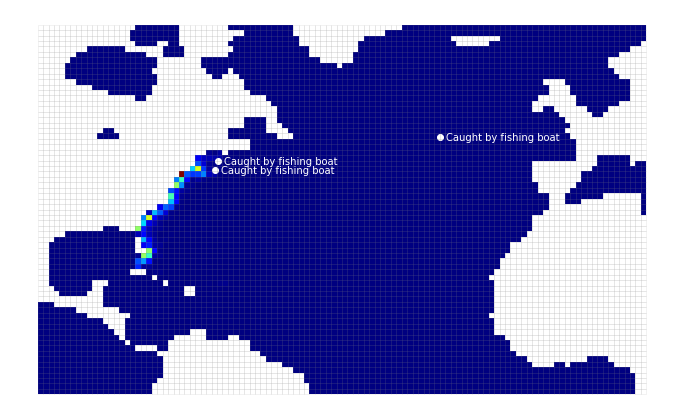

In [ ]:
ax = grid_na_t_gdf.plot(markersize=.1, figsize=(12, 8), column='n', cmap='jet')
plt.autoscale(False)
microtransat_boat_end = [(-25.9344000,47.3757600), (-67.3836430,41.2979880), (-66.9030130,42.8378230)] 
for pt in microtransat_boat_end:
  ax.scatter(pt[0], pt[1], color="white")
  ax.annotate("Caught by fishing boat", pt, color="white", xytext=(6,-3), textcoords="offset points")
combined_gdf.plot(ax=ax, facecolor='none', edgecolor='grey', alpha=.1)
ax.axis("off")

In [ ]:
combined_gdf = combined_gdf.merge(grid_na_t_gdf, on='geometry')

In [ ]:
combined_gdf.head()

,geometry,zlev,u_x,v_x,w,u_y,v_y,ug,vg,n
0,"POLYGON ((-99.00000 0.00000, -99.00000 1.00000...",10.0,-1.508128,5.452045,5.885843,-0.454072,-0.504904,-0.816768,-0.594510,0.0
1,"POLYGON ((-99.00000 1.00000, -99.00000 2.00000...",10.0,-0.981718,6.629486,6.960626,-0.672062,-0.498429,-1.096830,-0.636563,0.0
2,"POLYGON ((-99.00000 2.00000, -99.00000 3.00000...",10.0,-0.173407,7.265889,7.509792,-0.646119,-0.292941,-0.985076,-0.445447,0.0
3,"POLYGON ((-99.00000 3.00000, -99.00000 4.00000...",10.0,0.517940,7.577067,7.864586,-0.357129,-0.019079,-0.529972,-0.147251,0.0
4,"POLYGON ((-99.00000 4.00000, -99.00000 5.00000...",10.0,1.217792,7.374853,7.789278,0.108220,0.102816,0.010934,0.029647,0.0


In [ ]:
combined_gdf.head()

,geometry,zlev,u_x,v_x,w,u_y,v_y,ug,vg,n
0,"POLYGON ((-99.00000 0.00000, -99.00000 1.00000...",10.0,-1.508128,5.452045,5.885843,-0.454072,-0.504904,-0.816768,-0.594510,0.0
1,"POLYGON ((-99.00000 1.00000, -99.00000 2.00000...",10.0,-0.981718,6.629486,6.960626,-0.672062,-0.498429,-1.096830,-0.636563,0.0
2,"POLYGON ((-99.00000 2.00000, -99.00000 3.00000...",10.0,-0.173407,7.265889,7.509792,-0.646119,-0.292941,-0.985076,-0.445447,0.0
3,"POLYGON ((-99.00000 3.00000, -99.00000 4.00000...",10.0,0.517940,7.577067,7.864586,-0.357129,-0.019079,-0.529972,-0.147251,0.0
4,"POLYGON ((-99.00000 4.00000, -99.00000 5.00000...",10.0,1.217792,7.374853,7.789278,0.108220,0.102816,0.010934,0.029647,0.0


In [ ]:
combined_gdf['centroid'] = combined_gdf['geometry'].centroid

In [ ]:
combined_gdf['c_s'] = np.hypot(combined_gdf['u_x'], combined_gdf['v_x'])

# Simulation
This simulation is a simplified model which
- moves the vehicle based on surface current
- moves the vehicle based on wind


In [ ]:
def coords_to_gdf(coords):
  crs={'init':'epsg:4236'} # Coordinate Reference System
  dummy_df = pd.DataFrame()
  dummy_df['Attrib'] = [1,]
  path = LineString(coords)
  path_gdf = geopandas.GeoDataFrame(dummy_df, geometry=[path])
  return path_gdf

In [ ]:
def vis_map(map_gdf, coords_gdf, lines=True, title='Map Visualization'):
  """Visualize North Atlantic"""
  p = map_gdf.plot(figsize=(12,8), column='zlev', cmap='jet')
  if(lines):
    western_line_data.plot(ax=p, color='green')
    eastern_line_data.plot(ax=p, color='red')
  
  map_gdf.plot(ax=p, facecolor='none', edgecolor='gray', alpha=.1)
  coords_gdf.plot(ax=p, color='orange')
  plt.title(title)
  plt.xlabel('longitude')
  plt.ylabel('latitude')
  plt.show()

In [ ]:
def current_delta(curr_x, curr_y, coeff=1):
  """Simple function for calculating change in position based on current"""
  d_x = coeff * curr_x / 111000
  d_y = coeff * curr_y / 111000
  return d_x, d_y
def wind_delta(wind_x, wind_y, coeff=1):
  """Simple function for calculating change in position based on wind"""
  d_x = coeff * wind_x / 111000
  d_y = coeff * wind_y / 111000
  return d_x, d_y
def prob_interference(num_ships, area, vis_range=450, prob_interfere=.1):
  """Function for determining probability of ship interfering"""
  vis_area = math.pi * (vis_range ** 2)
  prob_sighting = vis_area / area
  prob_interrupt = prob_interfere * prob_sighting * num_ships
  return prob_interrupt
def within_area(gdf, x, y):
  xmin, ymin, xmax, ymax = gdf.total_bounds
  if y > ymin and y < ymax and x > xmin and x < xmax:
    return True
  else:
    return False

In [ ]:
# https://www.robsonforensic.com/articles/visibility-factors-in-small-boat-collisions-expert-research
# Need to add projections in future versions, for now approximate
# https://www.usna.edu/Users/oceano/pguth/md_help/html/approx_equivalents.htm
# 1 degree = 111 km

In [ ]:
def simulation(gdf, start_coords, vehicle_params, max_iterations=50, 
               rng=None, timestep=10000):
  # Start condition
  coords = [start_coords]
  grid_cell_area = 111000.0**2
  curr_coeff = 1
  factor = timestep

  # Simulation loops until max_iterations or termination condition
  for i in range(max_iterations):
    co = coords[i]
    try:
      # Current vector components
      curr_x = gdf.cx[co[0], co[1]].head(1).u_x.values[0]
      curr_y = gdf.cx[co[0], co[1]].head(1).v_x.values[0]
      # Wind vector components
      wind_x = gdf.cx[co[0], co[1]].head(1).u_y.values[0]
      wind_y = gdf.cx[co[0], co[1]].head(1).v_y.values[0]
      # Ship density
      num_ships = gdf.cx[co[0], co[1]].head(1).n.values[0]
    except:
      if (within_area(gdf, co[0], co[1])):
        return ('Termination: Beached', coords)
      return ('Termination: Invalid', coords)
      
    # Calculate interference occurence
    if num_ships > 0 and rng is not None:
      pr_int = prob_interference(num_ships, grid_cell_area)
      r = rng.random()
      if r < pr_int:
        return ('Termination: Interference', coords)  

    # Get current deltas
    cd_x, cd_y = current_delta(curr_x, curr_y, coeff=1)
    # Get wind deltas
    wd_x, wd_y = wind_delta(wind_x, wind_y, coeff=1)
    # Calculate new position
    d_x = factor * (cd_x + wd_x)
    d_y = factor * (cd_y + wd_y)
    new_x = co[0] + d_x
    new_y = co[1] + d_y
    if math.isnan(new_x) or math.isnan(new_y):
      return ('Termination: Beached', coords)
    
    # Add new position to list
    coords.append([new_x, new_y])

  return ('Termination: Max Time Steps', coords)

In [ ]:
rng = np.random.default_rng(seed=74)
def add_gaussian_noise(gdf, rng, scale=.075):
  random_cols = ["u_x", "v_x", "w", "u_y", "v_y", "u_g", "v_g"]
  gdf_copy = gdf.copy()
  for col in gdf_copy.columns:
    if col in random_cols:
      stdev = gdf_copy[col].std()
      mean = gdf_copy[col].mean()
      gdf_copy[col] += rng.normal(loc=mean, scale=stdev * scale, size=gdf_copy[col].size)
  gdf_copy['centroid'] = gdf_copy['geometry'].centroid
  gdf_copy['c_s'] = np.hypot(gdf_copy['u_x'], gdf_copy['v_x'])
  return gdf_copy

In [ ]:
# combined_gdf.head()
# combined_gdf_noise = add_gaussian_noise(combined_gdf, 0.075)
# simulation(combined_gdf_noise, (-66.088, 38.4152), .9, 100)

Termination: Interference


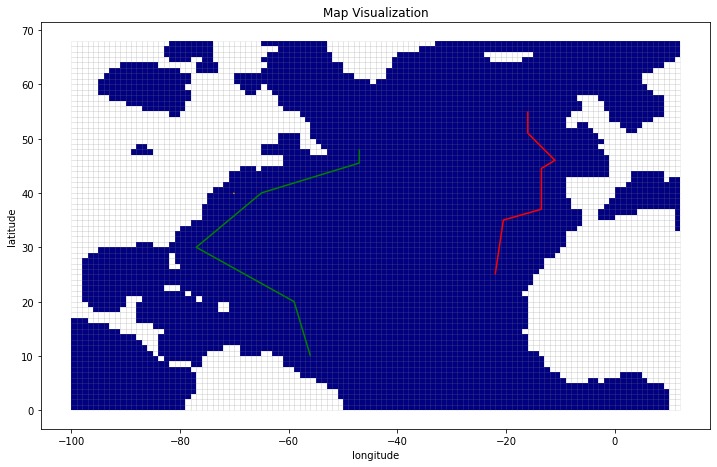

In [ ]:
exit_condition, sim_coords = simulation(combined_gdf, (-70, 40), .9, 200, rng=rng)
print(exit_condition)
sim_gdf = coords_to_gdf(sim_coords)
vis_map(combined_gdf, sim_gdf)

In [ ]:
simulation(combined_gdf, (-66.088, 38.4152), .9, 100, rng=rng)

('Termination: Max Time Steps',
 [(-66.088, 38.4152),
  [-66.03275111395156, 38.45584582958093],
  [-65.97750222790313, 38.49649165916186],
  [-65.85067947429968, 38.5739279203916],
  [-65.72385672069623, 38.65136418162133],
  [-65.59703396709278, 38.72880044285107],
  [-65.47021121348934, 38.8062367040808],
  [-65.34338845988589, 38.88367296531054],
  [-65.21656570628244, 38.96110922654027],
  [-65.08974295267899, 39.03854548777001],
  [-65.03440807317152, 39.02565121756697],
  [-64.97907319366405, 39.012756947363926],
  [-64.88310260177566, 39.06076649465949],
  [-64.78713200988727, 39.10877604195505],
  [-64.69116141799888, 39.15678558925062],
  [-64.5951908261105, 39.20479513654618],
  [-64.49922023422211, 39.252804683841745],
  [-64.40324964233372, 39.30081423113731],
  [-64.30727905044533, 39.34882377843287],
  [-64.21130845855694, 39.39683332572844],
  [-64.11533786666855, 39.444842873024],
  [-64.01936727478017, 39.492852420319565],
  [-63.92339668289177, 39.54086196761513],
  

# Validation
https://apps-nefsc.fisheries.noaa.gov/drifter/

In [ ]:
def load_drift_data(f):
  driftset = pd.read_csv(f)
  driftset = driftset.drop(columns=['MTH', 'DAY', 'HR_GMT', 'MIN', 'YEARDAY', 'DEPTH'])
  driftlist = []
  for id, df_id in driftset.groupby('ID'):
    driftlist.append(df_id)
  return driftlist

In [ ]:
drifters = load_drift_data('drift_ep_2018_1.csv')
len(drifters)

14

In [ ]:
def euclidean_dist(x1, y1, x2, y2):
  return (math.sqrt((abs(x1-x2)**2 + abs(y1-y2)**2)))

def metric_one(gdf, base_path, timestep):
  errors = []
  exit_conditions = []
  for i in range(len(base_path)-1):
    coords = base_path[i]
    exit_condition, path = simulation(gdf, coords, 1, max_iterations=1, timestep=timestep)
    error = euclidean_dist(*path[-1], *base_path[i+1])
    errors.append(error)
    exit_conditions.append(exit_condition)
  avg_error = statistics.mean(errors)
  stdev = statistics.stdev(errors)
  return (avg_error, stdev)

def metric_two(gdf, base_path, timestep, max_iterations=50):
  exit_condition, path = simulation(gdf, base_path[0], 1, 
                                    max_iterations=max_iterations, 
                                    timestep=timestep)
  error = euclidean_dist(*path[-1], *base_path[-1])
  return error, exit_condition, path

def trajectory_validation(base_path, max_iterations=50, seed=42, n=5, timestep=43200):
  rng = np.random.default_rng(seed)
  curr_gdf = add_gaussian_noise(combined_gdf, rng)
  avg_error_one, stdev_one = metric_one(curr_gdf, base_path, 42300)

  errors_two = []
  ec_two = []
  paths = []
  i = 0
  for i in range(n):
    curr_gdf = add_gaussian_noise(combined_gdf, rng)
    error_two, exit_condition, p = metric_two(curr_gdf, base_path, 
                                              timestep=timestep,
                                              max_iterations=max_iterations)

    errors_two.append(error_two)
    ec_two.append(exit_condition)
    paths.append(p)
  avg_error_two = statistics.mean(errors_two)
  stdev_two = statistics.stdev(errors_two)

  print("Metric One:")
  print("Average Error:", avg_error_one, " Standard Deviation:", stdev_one)
  print("Metric Two:")
  print("Average Error:", avg_error_two, " Standard Deviation:", stdev_two)

  return (avg_error_one, stdev_one, avg_error_two, stdev_two, errors_two, ec_two, paths)

### Case 1
Approximate timestep = 12 hours = 43200 seconds


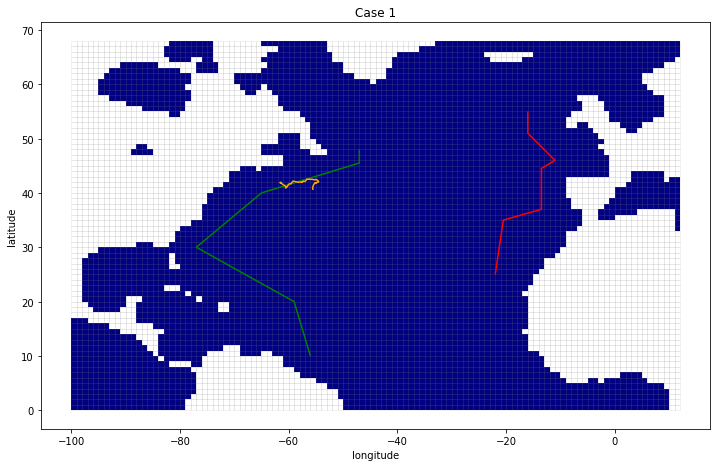

In [ ]:
path1 = list(zip(drifters[0]['LON'], drifters[0]['LAT']))[450:500]
case1_gdf = coords_to_gdf(path1)
vis_map(combined_gdf, case1_gdf, title="Case 1")

In [ ]:
ao, so, ae2, se2, e2, ec2, p2 = trajectory_validation(path1)
print(ec2)

Metric One:
Average Error: 0.7399890347036183  Standard Deviation: 0.24965640087684843
Metric Two:
Average Error: 31.393087821631475  Standard Deviation: 0.9766131725377283
['Termination: Max Time Steps', 'Termination: Max Time Steps', 'Termination: Max Time Steps', 'Termination: Max Time Steps', 'Termination: Max Time Steps']


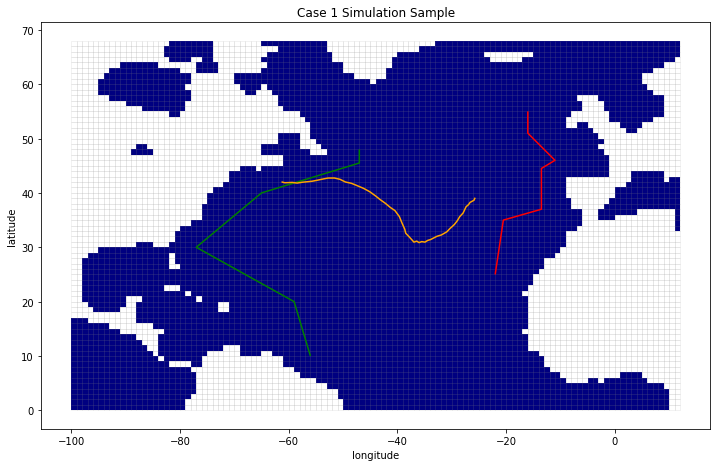

In [ ]:
check_gdf = coords_to_gdf(p2[0])
vis_map(combined_gdf, check_gdf, title='Case 1 Simulation Sample')

### Case 2
Approximate timestep = 12 hours = 43200 seconds


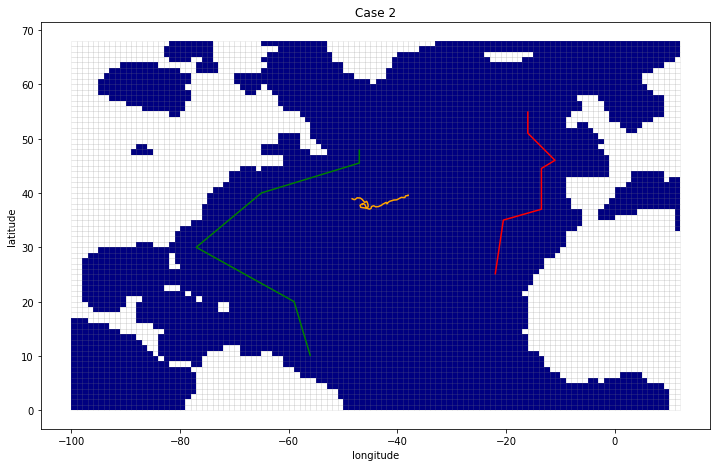

In [ ]:
path2 = list(zip(drifters[1]['LON'], drifters[1]['LAT']))[50:100]
case2_gdf = coords_to_gdf(path2)
vis_map(combined_gdf, case2_gdf, title="Case 2")

In [ ]:
c2_ao, c2_so, c2_ae2, c2_se2, c2_e2, c2_ec2, c2_p2 = trajectory_validation(path2)
print(c2_ec2)

Metric One:
Average Error: 0.8115790744082398  Standard Deviation: 0.27637340336634847
Metric Two:
Average Error: 34.226878095053195  Standard Deviation: 2.3425464864373087
['Termination: Beached', 'Termination: Max Time Steps', 'Termination: Max Time Steps', 'Termination: Max Time Steps', 'Termination: Max Time Steps']


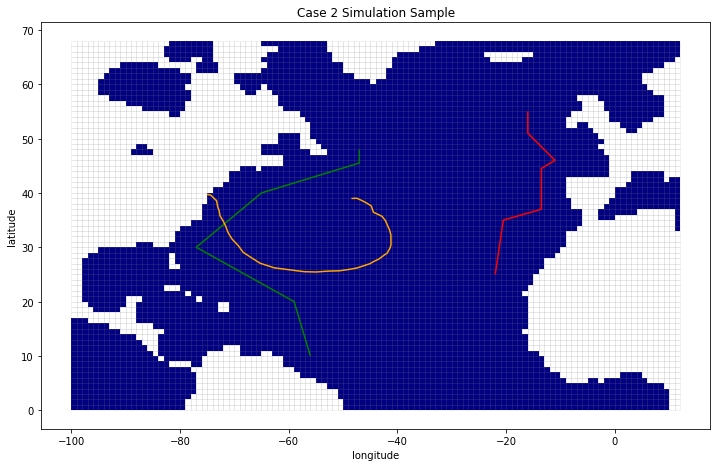

In [ ]:
check_gdf = coords_to_gdf(c2_p2[0])
vis_map(combined_gdf, check_gdf, title='Case 2 Simulation Sample')

### Case 3
Approximate timestep = 12 hours = 43200 seconds


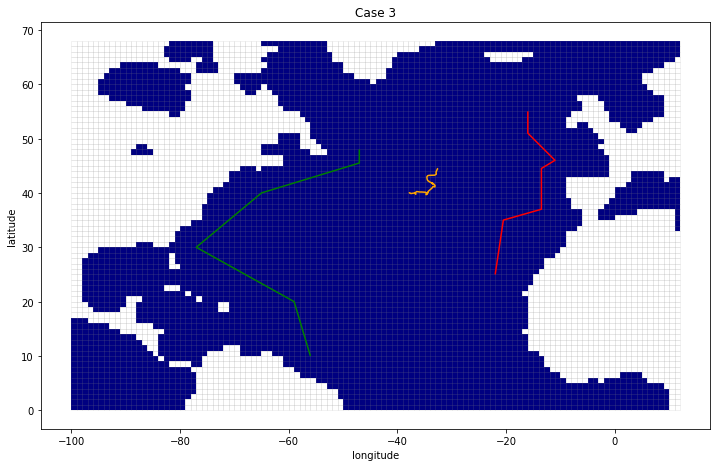

In [ ]:
path3 = list(zip(drifters[1]['LON'], drifters[1]['LAT']))[100:150]
case3_gdf = coords_to_gdf(path3)
vis_map(combined_gdf, case3_gdf, title="Case 3")

In [ ]:
c3_ao, c3_so, c3_ae2, c3_se2, c3_e2, c3_ec2, c3_p2 = trajectory_validation(path3)
print(c3_ec2)

Metric One:
Average Error: 1.0727195829888623  Standard Deviation: 0.40727953496769004
Metric Two:
Average Error: 28.052602655312686  Standard Deviation: 1.7493539981551787
['Termination: Beached', 'Termination: Beached', 'Termination: Beached', 'Termination: Beached', 'Termination: Beached']


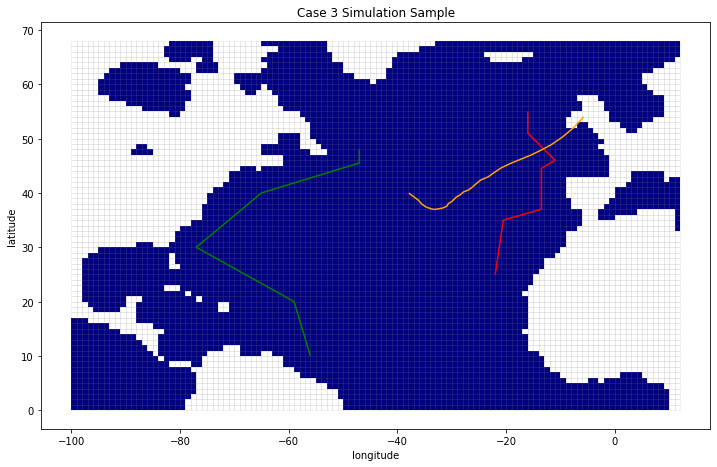

In [ ]:
check_gdf = coords_to_gdf(c3_p2[0])
vis_map(combined_gdf, check_gdf, title='Case 3 Simulation Sample')

## Intial Study

In [ ]:
rng = np.random.default_rng(42)

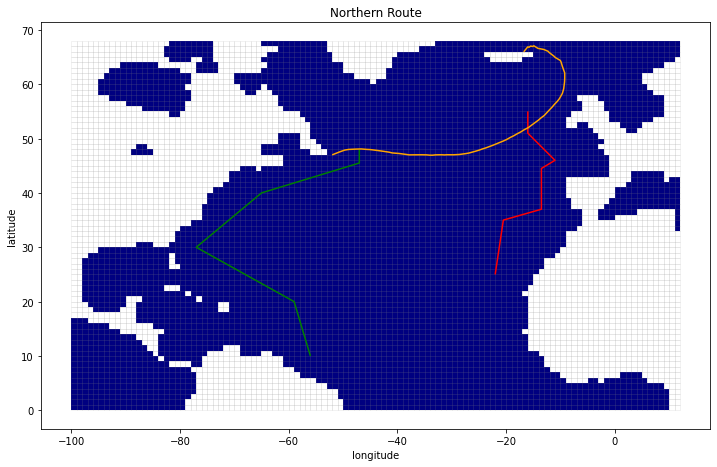

In [ ]:
study_gdf = add_gaussian_noise(combined_gdf, rng, scale=.075)
exit_condition, path = simulation(study_gdf, (-52, 47), 1, max_iterations=300, timestep=10000)
north_gdf = coords_to_gdf(path)
vis_map(combined_gdf, north_gdf, title="Northern Route")

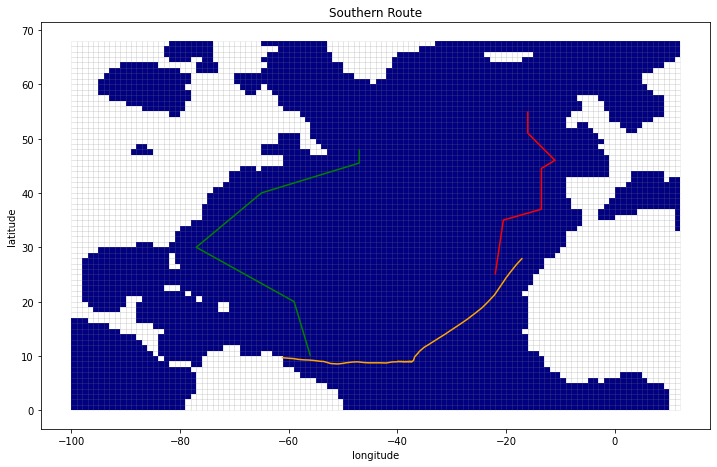

In [ ]:
study2_gdf = add_gaussian_noise(combined_gdf, rng, scale=.075)
exit_condition, path = simulation(study_gdf, (-17, 28), 1, max_iterations=300, timestep=10000)
south_gdf = coords_to_gdf(path)
vis_map(combined_gdf, south_gdf, title="Southern Route")